# TRABAJO MACHINE LEARNING: CLASIFICACIÓN DE VINOS

### Autores: Jon Imaz Dravasa y Jorge Vera Aguinaga
#### Fecha: 04/11/2023

![redwine.jpg](https://storage.googleapis.com/kaggle-datasets-images/4458/6836/30587db9a40233164f65a4a3f148f40d/dataset-cover.jpg?t=2017-11-12-14-28-34)

<br><br>

## 1. Presentación del problema

---



---


Una de las principales inquietudes de los restaurantes de mayor nivel, es la utilización de vinos de la mayor calidad y exquisitez posible. Si bien existen cartas donde se recopilan algunas de las reservas más famosas del mundo, estas no contiene todos las variaciones del mundo, por lo que en ocasiones es necesario llevar a cabo un estudio de vinos anónimos en función de sus características para ponerles nota. Esto trae consigo otra problemática, es criterio por el cual se califica cada vino, ya que distintos jueces u organizaciones pueden llevar a cabo veredictos muy distintos. 

Siendo esto así, en este cuaderno se llevarán a cabo experimentos con distintas técnicas de machine learning con el fin de obtener un modelo capaz de calificar el vino. El modelo será entrenado utilizando distintos veredictos de forma que este aúne lo mejor posible los criterios de los catadores de vino.

<br>

## 2. Estructura del dataset

---



---

El dataset que se utilizará en este cuaderno ha sido proporcionado por la plataforma de Kaggle. Este posee la siguiente estructura:

- **Fixed acidity**
- **Volatile acidity**
- **Citric acidity**
- **Residual sugar**
- **Chlorides**
- **Free sulfur dioxide**
- **Total sulfur dioxide**
- **Density**
- **pH**
- **Sulphates**
- **Alcohol**
- **Quality**

El campo que trataremos de predecir, como ya hemos mencionado anteriormente, será "Quality", de forma que el resto de campos químicos actuarán como features, variables en los modelos para sacar conclusiones sobre la calidad del vino.

<br>

## 3. Paquetes y preprocesado de los datos

---



---

#### 3.1. Librerías


En la siguiente casilla de Python se presentan las librerias que se utilizarán para este proyecto.

In [1]:
# Cargar librerias comunes.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import random

# Cargamos librerias de sklearn para modelos de machine learning.
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

!pip install graphviz
from graphviz import Source
from sklearn.tree import export_graphviz

!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

# Evitamos los warnings.
warnings.filterwarnings('ignore')

# Aplicamos una seed para que los resultados no sean aleatorios.
random.seed(100)

# Iniciamos el directorio de trabajo.
#path = 'C:/Users/user/Desktop/Tecnun - Universidad de Navarra/Master/Máster en Análisis de Datos/1º Bimestre/Machine Learning/ML Vino'
path = 'C:/Users/jonid/OneDrive - UNIVERSIDAD SAN JORGE/MADI/MachineLearning/Grupal/ML Vino'
os.chdir(path)

#### 3.2. Lectura del dataset, separación de train-test y preprocesado del dataset.

Comenzamos leyendo y mostrando la estructura del dataset que ya hemos declarado.

In [2]:
# Cargamos los datos.
df = pd.read_csv('winequality-red.csv', sep = ',')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Podemos observar que todos los campos de nuestro dataset son numericos, más concretamente de tipo "float64" -salvo el campo objetivo de quality, que es un campo "int64"-. Esto facilita el uso del dataset para nuestros modelos, pues no es necesario codificar ninguna feature.

Ya que estos campos poseen distintos ordenes de magnitud, aplicaremos un escalado de los datos para reducir esta varianza. Nuestro dataset no contiene entradas nulas o "Not Assigned", por lo que no será necesario llevar a cabo corrección de datos en este aspecto. Finalmente, se llevará a cabo la separación de los datos en datos de entrenamiento y de evaluación (train y test).

In [3]:
# Eliminamos las entradas NA.
df = df.dropna()

# Elegimos como variable categórica el valor de calidad del vino.
X = df.drop(['quality'], axis = 1)
y = df['quality']

# Separación de los datos en train y test: 20% de test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

# Standard Scaler.
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)


<br>

## 4. Modelos de Machine Learning

---



---

Los modelos que se emplearán en esta sección son modelos de machine learning de clasificación, tanto Supervised Learning como Unsupervised Learning. Se comenzará evaluando los modelos más sencillos para terminar con aquellos que posee una mayor complejidad (desde Decision Trees hasta Neural Networks).

#### 4.1. Decision Tree

Un árbol de decisión es una herramienta utilizada para tomar decisiones en función de información disponible. Puede imaginarse como una especie de juego de "Sí/No" que ayuda a llegar a una respuesta.

Esta toma de decisiones comienza por un "nodo raíz", el punto en el que convergen todas las ramas del árbol. Tras una toma de decisión para la clasificación, se pasa a una de las ramas, que lleva a otro nodo, el "nodo hoja", donde se ha de tomar otra decisión para la clasificación.

Para poder definir este modelo de forma óptima, utilizamos un GridSearchCV, que mediante una 5-fold Cross Validation, nos devolverá el modelo óptimo para los valores de los hiperparámetros proporcionados. Los hiperparámetros en este caso son:

- **criterion**: Función para medir la calidad de un split.
- **splitter**: Estrategia utilizada para elegir el split en cada nodo.
- **max_depth**: Profundidad máxima del árbol.
- **min_samples_split**: Número mínimo de muestras necesarias para dividir un nodo interno.
- **min_samples_leaf**: Número mínimo de muestras necesarias para ser una hoja.
- **max_features**: Número de features a considerar en cada split.
- **class_weight**: Pesos asociados a las clases.

In [8]:
# Creamos el modelo de Decision Trees.
dt_classifier = DecisionTreeClassifier()

# Definicion de los posibles parametros para el GridSearchCV (5-fold Cross Validation): Búsqueda del modelo óptimo.
tuned_paramaters = {
    'criterion': ['gini', 'entropy'],  
    'splitter': ['best', 'random'],   
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],    
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(estimator = dt_classifier, param_grid = tuned_paramaters, cv = 5)

# Fitting del modelo óptimo a los datos.
m_dt = grid.fit(X_train, y_train)
ypred_train = m_dt.predict(X_train)
ypred_test = m_dt.predict(X_test)

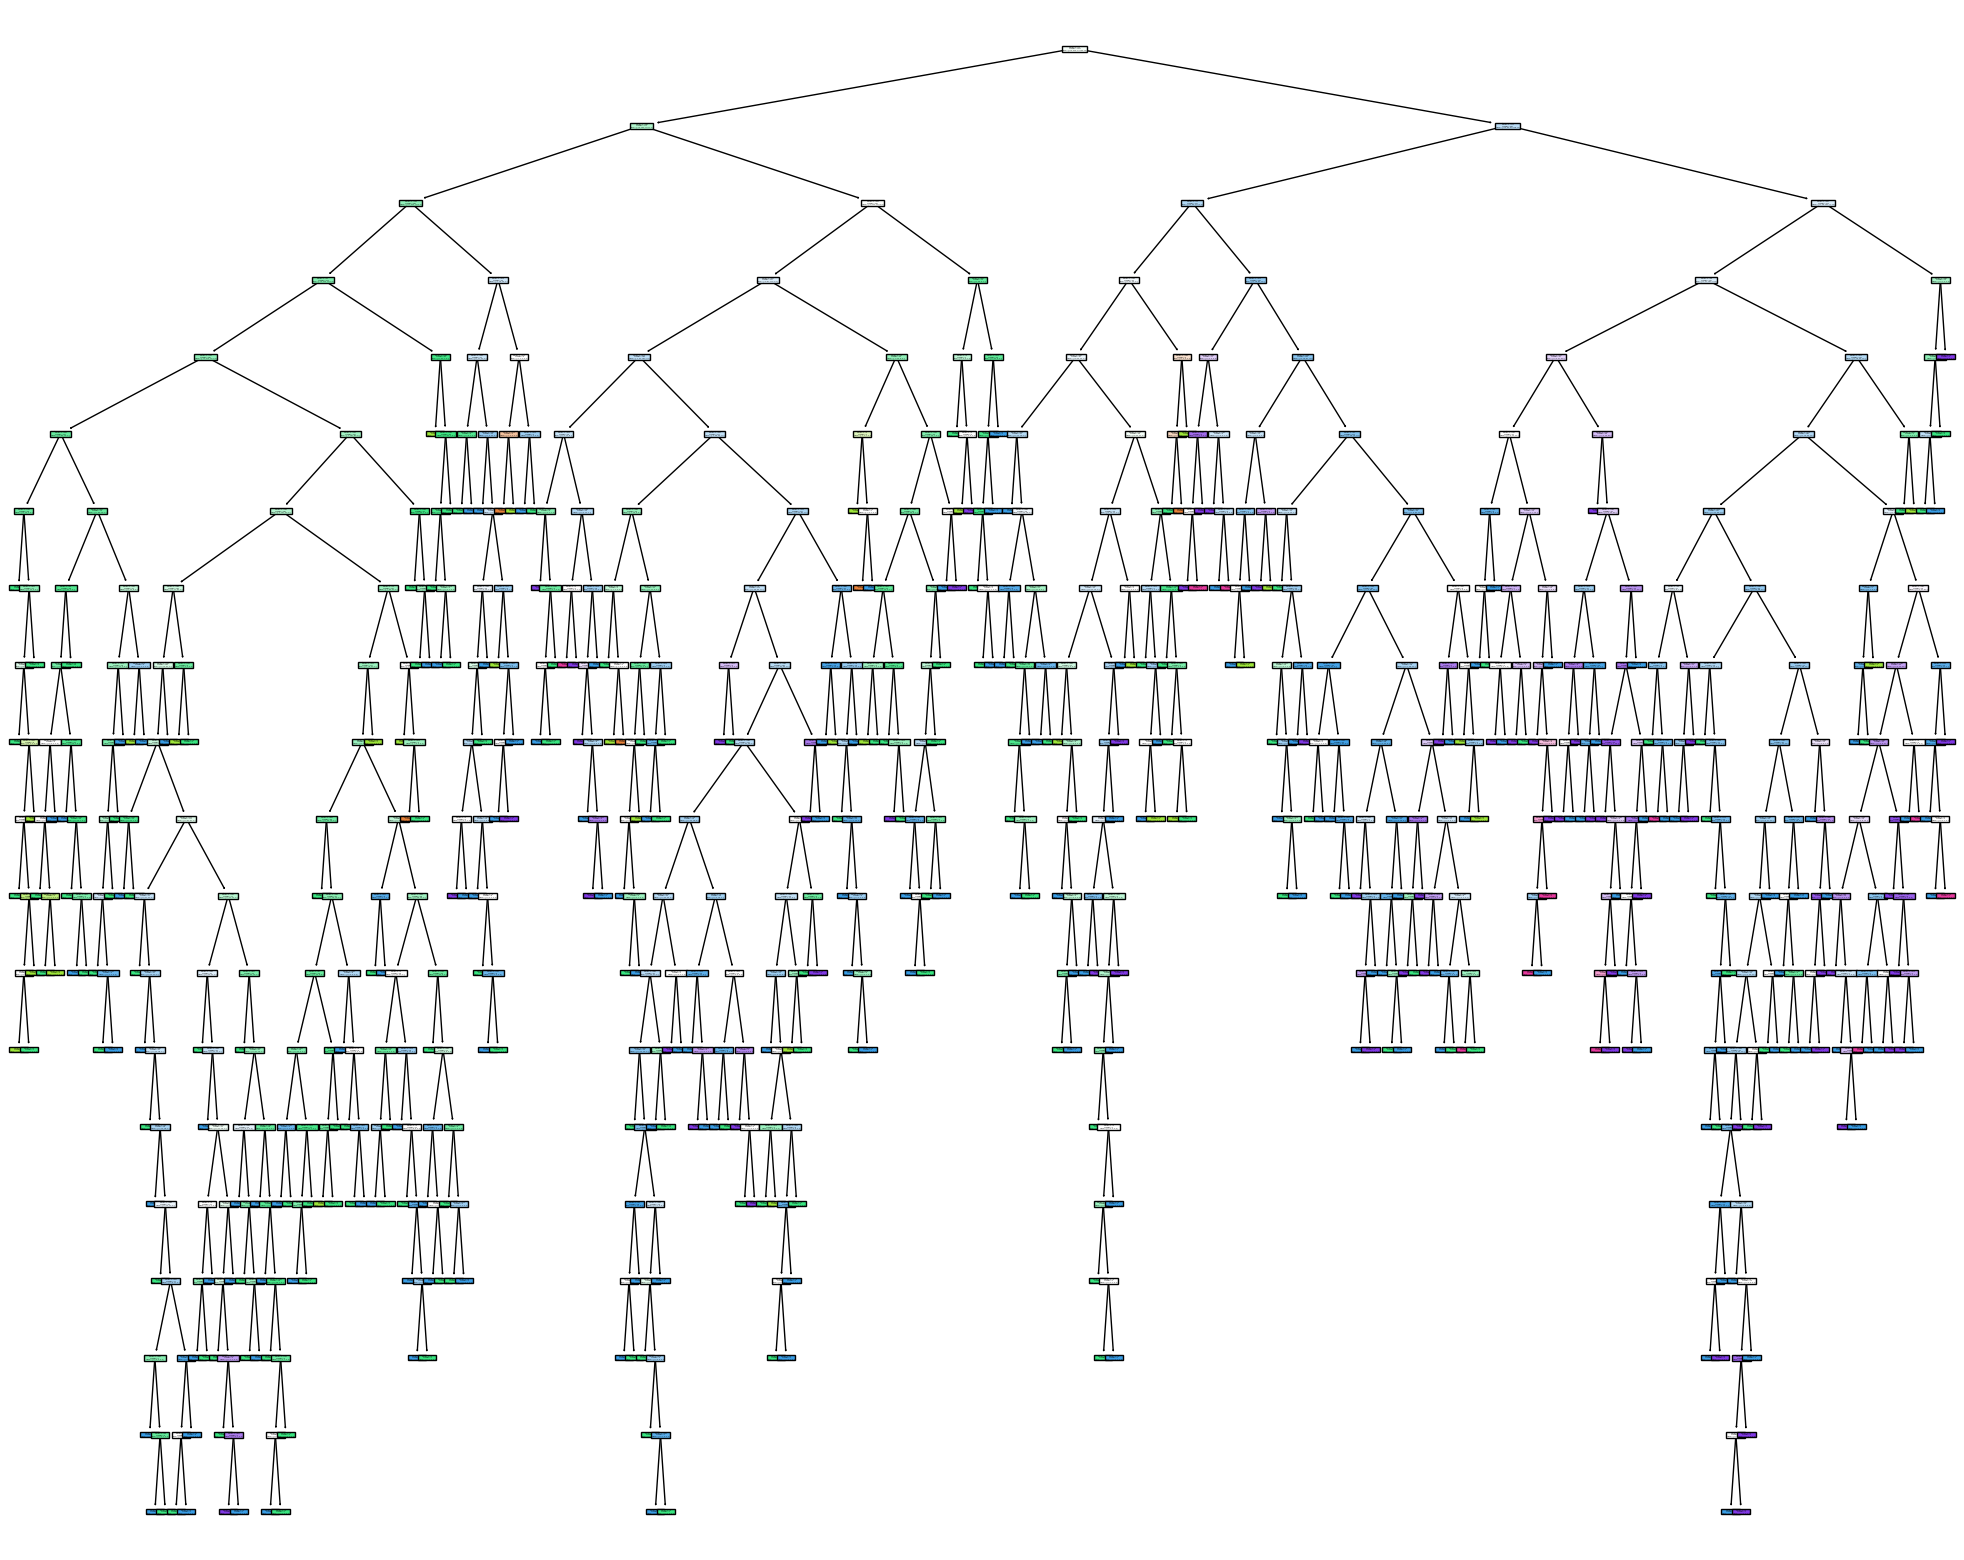

In [9]:
# Plot del arbol de decisión general.
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(m_dt.best_estimator_, feature_names=df.drop("quality", axis="columns").columns, filled=True)

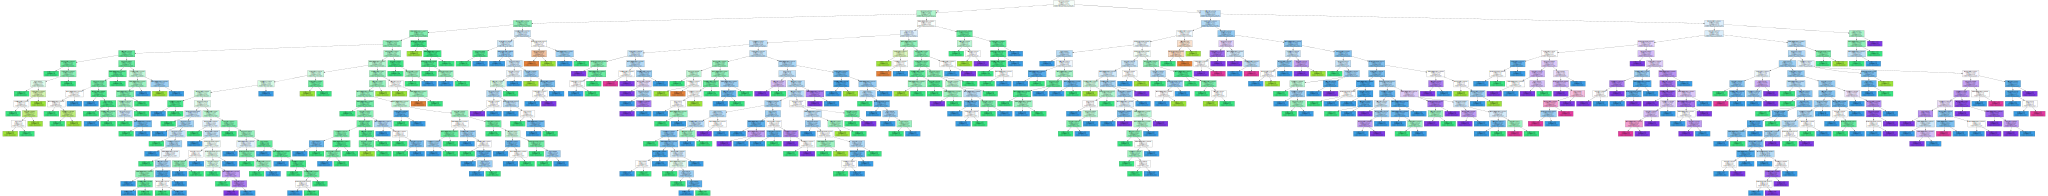

In [10]:
# Plot del arbol de decision a fondo.
export_graphviz(m_dt.best_estimator_, out_file='tree.dot', feature_names=df.drop("quality", axis="columns").columns, filled=True)
Source.from_file('tree.dot')

In [11]:
# Accuracy del modelo. 
print('Accuracy en train:', accuracy_score(y_train, ypred_train))
print('Accuracy en test:', accuracy_score(y_test, ypred_test))

# Mejores parámetros y matriz de confusión.
print('Mejores parámetros para Decision Tree: ', m_dt.best_params_, '\n')
print('Matriz de confusión en train:\n', confusion_matrix(y_train, ypred_train))
print('Matriz de confusión en test:\n', confusion_matrix(y_test, ypred_test))

Accuracy en train: 1.0
Accuracy en test: 0.528125
Mejores parámetros para Decision Tree:  {'class_weight': None, 'criterion': 'entropy', 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'} 

Matriz de confusión en train:
 [[  8   0   0   0   0   0]
 [  0  42   0   0   0   0]
 [  0   0 545   0   0   0]
 [  0   0   0 510   0   0]
 [  0   0   0   0 159   0]
 [  0   0   0   0   0  15]]
Matriz de confusión en test:
 [[ 0  1  1  0  0  0]
 [ 1  3  5  2  0  0]
 [ 0  4 83 44  4  1]
 [ 0  7 34 69 17  1]
 [ 0  0  3 23 14  0]
 [ 0  0  0  2  1  0]]


De los resultados se puede deducir que hay overfitting para nuestro modelo de Decision Tree, pues el score de entrenamiento es muy superior al de test. Esto se debe a que el modelo se ha ajustado demasiado a los datos de entrenamiento, por lo que no es capaz de generalizar bien para los datos de test. El modelo de Decision Tree es un modelo de clasificación simple que, pese a poseer una complejidad muy baja, tiende a este tipo de defectos (overfitting).

Siendo esto así, buscaremos el uso de un modelo más complejo que sea capaz de generalizar mejor para los datos de test.

#### 4.2. Random Forest

Un modelo de Random Forest es un modelo de ensamblado de árboles de decisión. Este modelo se basa en la creación de múltiples árboles de decisión, de forma que cada uno de estos árboles se entrena con una muestra aleatoria del dataset. Una vez entrenados todos los árboles, se realiza una predicción con cada uno de ellos y se elige la predicción que más se repite.

De la misma forma que en el caso anterior, utilizaremos un GridSearchCV para obtener el modelo óptimo para los hiperparámetros proporcionados. Los hiperparámetros en este caso son:

- **n_estimators**: Número de árboles en el bosque (En nuestro caso se deja como default).
- **criterion**: Función para medir la calidad de un split.
- **max_depth**: Profundidad máxima del árbol.
- **min_samples_split**: Número mínimo de muestras necesarias para dividir un nodo interno.
- **min_samples_leaf**: Número mínimo de muestras necesarias para ser una hoja.
- **max_features**: Número de features a considerar en cada split.
- **class_weight**: Pesos asociados a las clases.


In [12]:
# Creamos el modelo de Random Forests.
rf_classifier = RandomForestClassifier()

# Definicion de los posibles parametros para el GridSearchCV (5-fold Cross Validation): Búsqueda del modelo óptimo.
tuned_paramaters = {
    'n_estimators': [300],
    'criterion': ['gini', 'entropy'],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],    
    'max_features': ['auto', 'sqrt', 'log2'],  
    'class_weight': [None, 'balanced']  
}

grid = GridSearchCV(estimator = rf_classifier, param_grid = tuned_paramaters, cv = 5)

# Fitting del modelo óptimo a los datos.
m_rf = grid.fit(X_train, y_train)
ypred_train = m_rf.predict(X_train)
ypred_test = m_rf.predict(X_test)

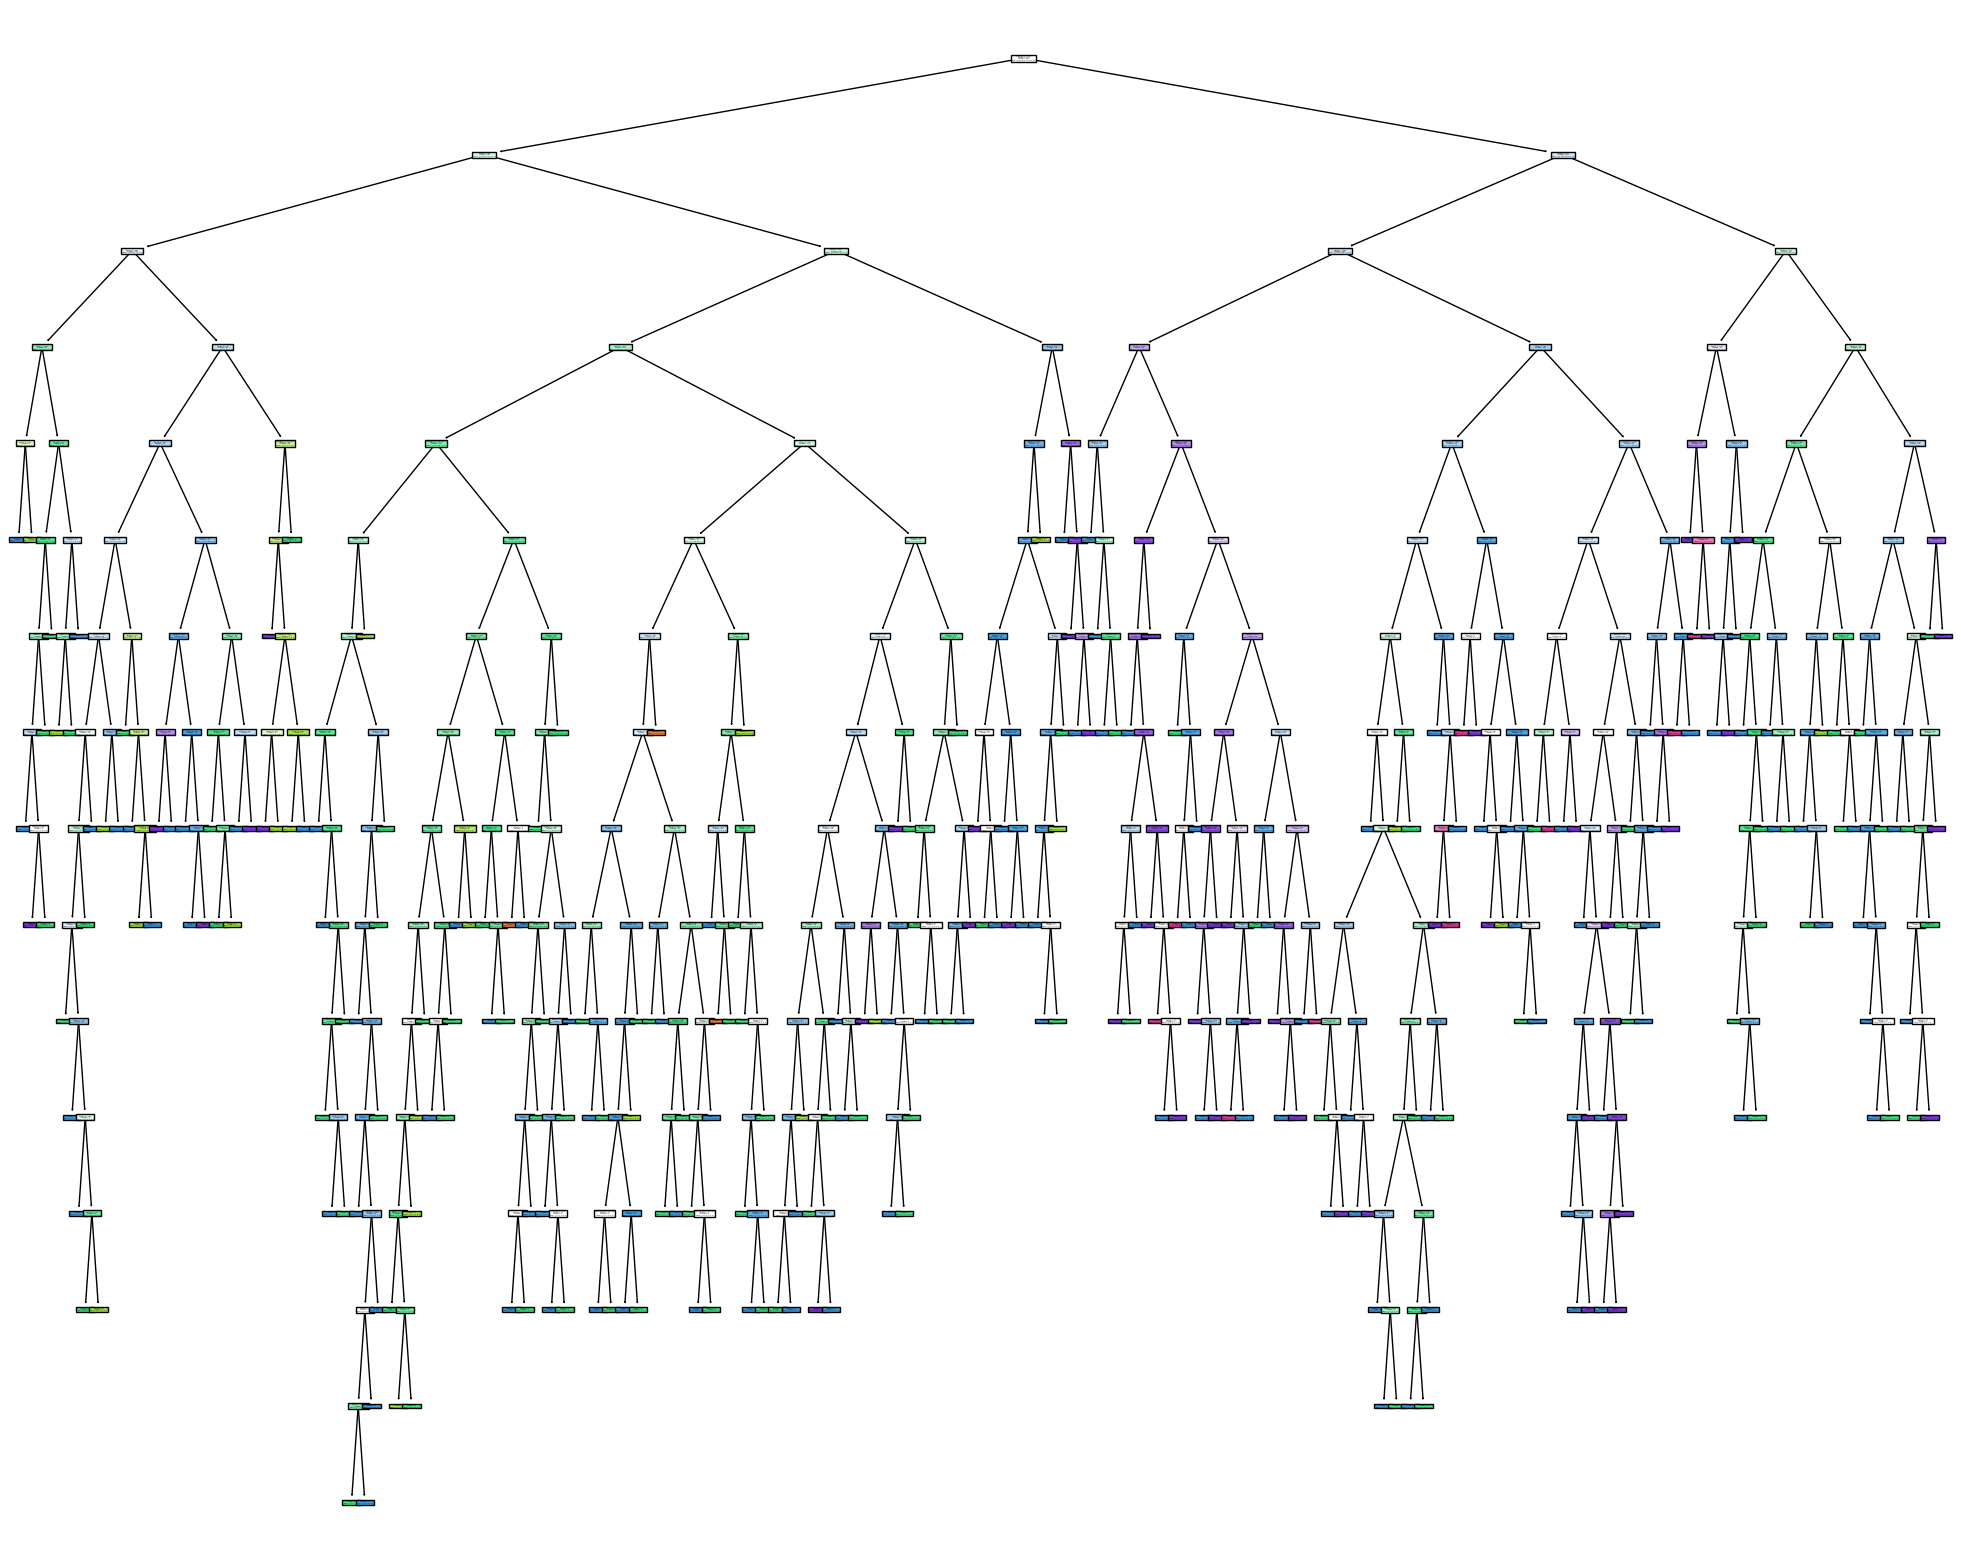

In [13]:
# Plot del random forest general.
fig = plt.figure(figsize=(25, 20))
_ = tree.plot_tree(m_rf.best_estimator_.estimators_[0], feature_names=df.drop("quality", axis="columns").columns, filled=True)

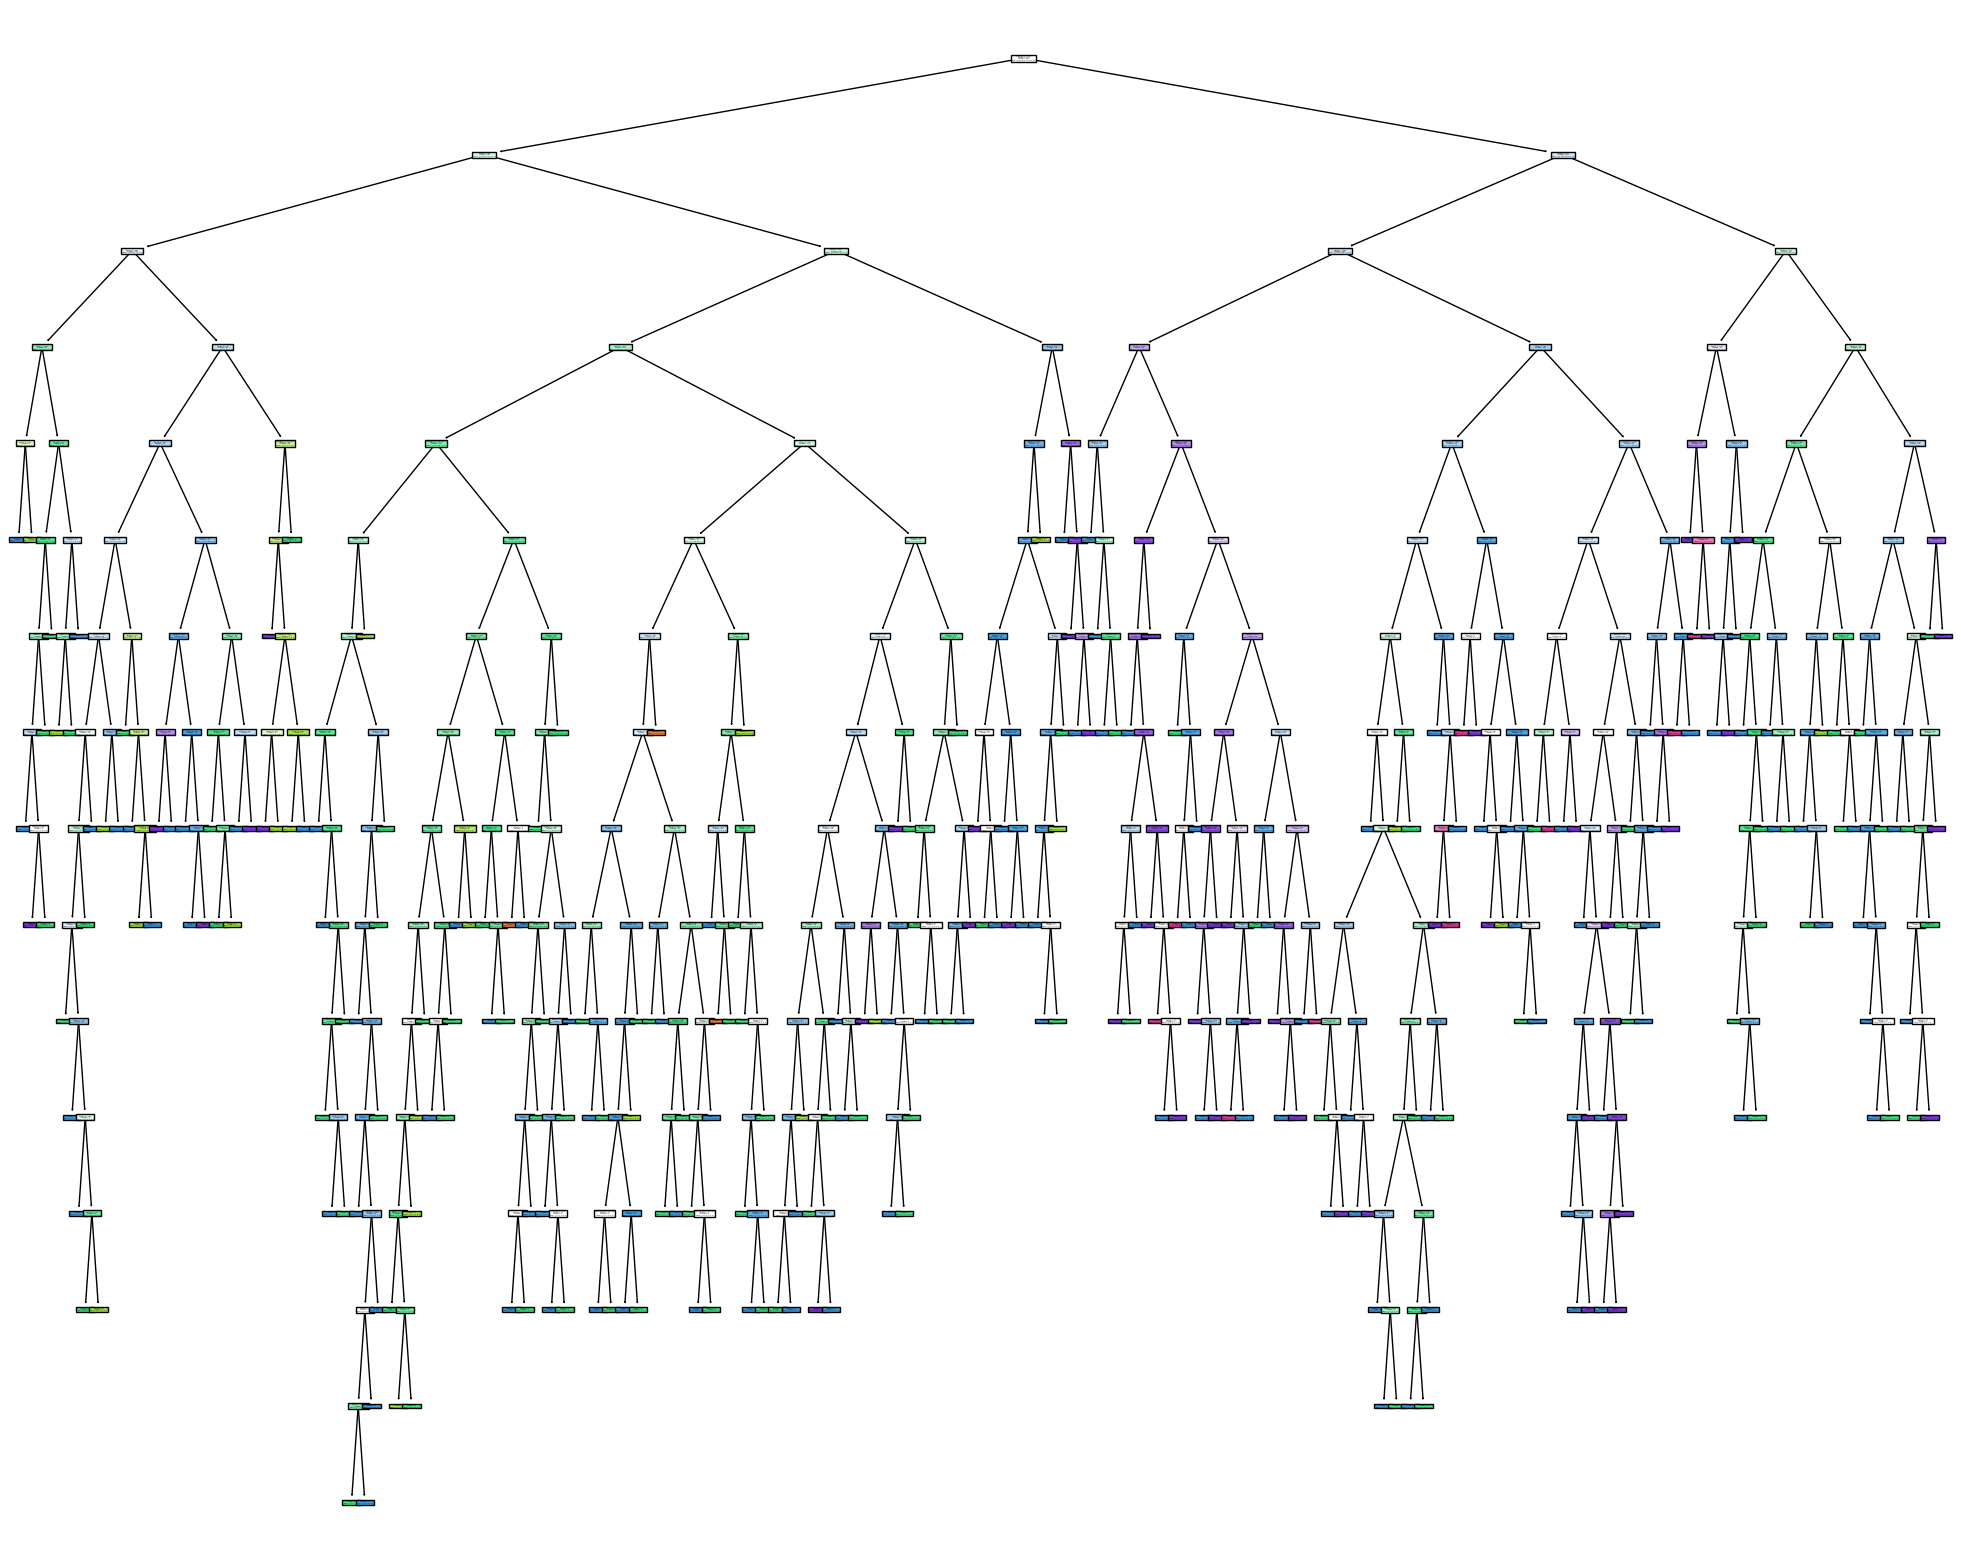

In [14]:
# Plot del random forest general.
fig = plt.figure(figsize=(25, 20))
_ = tree.plot_tree(m_rf.best_estimator_.estimators_[0], feature_names=df.drop("quality", axis="columns").columns, filled=True)

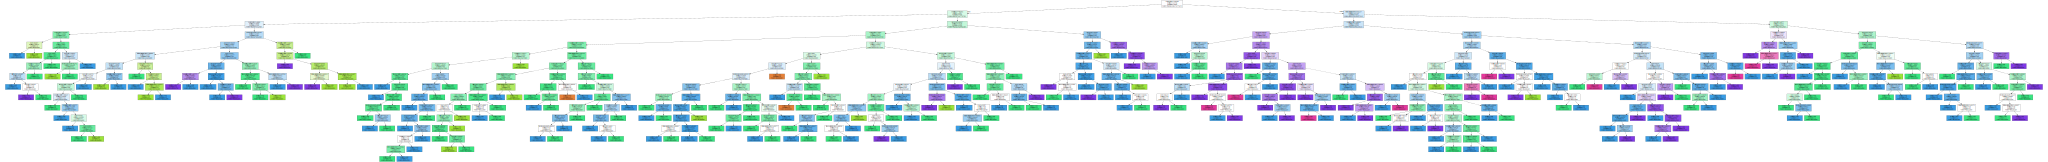

In [15]:
# Plot del random forest en detalle.
export_graphviz(m_rf.best_estimator_.estimators_[0], out_file='forest.dot', feature_names=df.drop("quality", axis="columns").columns, filled=True)
Source.from_file('forest.dot')

In [16]:
# Accuracy del modelo. 
print('Accuracy en train:', accuracy_score(y_train, ypred_train))
print('Accuracy en test:', accuracy_score(y_test, ypred_test))

# Mejores parámetros y matriz de confusión.
print('Mejores parámetros para Decision Tree: ', m_rf.best_params_, '\n')
print('Matriz de confusión en train:\n', confusion_matrix(y_train, ypred_train))
print('Matriz de confusión en test:\n', confusion_matrix(y_test, ypred_test))

Accuracy en train: 1.0
Accuracy en test: 0.653125
Mejores parámetros para Decision Tree:  {'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2} 

Matriz de confusión en train:
 [[  8   0   0   0   0   0]
 [  0  42   0   0   0   0]
 [  0   0 545   0   0   0]
 [  0   0   0 510   0   0]
 [  0   0   0   0 159   0]
 [  0   0   0   0   0  15]]
Matriz de confusión en test:
 [[  0   1   1   0   0   0]
 [  0   0   9   2   0   0]
 [  0   0 101  33   2   0]
 [  0   0  31  89   8   0]
 [  0   0   2  19  19   0]
 [  0   0   0   2   1   0]]


Pese a haber mejorado el score de test, el modelo anterior sigue presentando overfitting. Siendo esto así, probaremos ahora con un modelo distinto, basado en el uso de Support Vector Machines.

#### 4.3. Support Vector Machine

Un algoritmo de Support Vector Machines consiste en la búsqueda de un hiperplano que separe los datos de entrada en dos clases. Este hiperplano se define como el que posee la mayor distancia a los puntos de datos de ambas clases. En nuestro caso, ya que se trata de un problema de clasificación, se utilizará un modelo de Support Vector Classifier (SVC), donde, además, nuestro caso es multiclase, por lo que se necesitará definir un criterior de separación de clases One-vs-One o One-vs-Rest. Este último es el que se utilizará en este caso (método por defecto).

In [5]:
# Crear un clasificador SVM
svm_classifier = SVC(decision_function_shape='ovr')

# Crear un objeto GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale', 'auto'],
}

grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando la búsqueda de hiperparámetros en los datos de entrenamiento
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Calcular el informe de clasificación en los datos de prueba utilizando el modelo con los mejores hiperparámetros
best_svm_classifier = grid_search.best_estimator_
print('Confusion matrix: \n')
print(confusion_matrix(y_test, y_pred))
print("Informe de clasificación en datos de prueba:")
print(classification_report(y_test, best_svm_classifier.predict(X_test)))

Mejores hiperparámetros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Confusion matrix: 

[[ 0  1  1  0  0  0]
 [ 0  0  9  2  0  0]
 [ 0  3 95 36  2  0]
 [ 0  0 40 77 11  0]
 [ 0  0  3 13 23  1]
 [ 0  0  0  1  2  0]]
Informe de clasificación en datos de prueba:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.64      0.70      0.67       136
           6       0.60      0.60      0.60       128
           7       0.61      0.57      0.59        40
           8       0.00      0.00      0.00         3

    accuracy                           0.61       320
   macro avg       0.31      0.31      0.31       320
weighted avg       0.59      0.61      0.60       320



Podemos ver como el modelo ha sido optimizdo para la utilización de una función kernel "rbf". Esta función kernel es una función de base radial, que se utiliza para la clasificación de datos no linealmente separables. Esta función kernel se define como:

$$K(x_i, x_j) = exp(-\gamma ||x_i - x_j||^2)$$

Los resultados del modelo nos muestran que se trata de un método más robusto para nuestros datos que el modelo de árboles de decisión, pero sigue estando por detrás de nuestro modelo de Random Forest.

#### 4.4. K-Vecinos más Cercanos (K-NN)

Se define a continuación un modelo de K-Vecinos más Cercanos (K-NN). Este modelo se basa en la clasificación de los datos en función de la clase de los K vecinos más cercanos. Para ello, se utiliza una función de distancia, que en nuestro caso será la distancia euclídea.

Vamos a analizar la evolución de los resultados en las diferentes fases del proceso de clasificación utilizando el algoritmo K-NN para predecir la calidad del vino y cómo la aplicación de diferentes técnicas ha impactado la precisión del modelo.

##### Fase1: K-NN Básico

In [18]:
# Crear el clasificador K-NN y ajustar el modelo
k = 3  # Puedes ajustar el valor de k según sea necesario
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
print('Confusion matrix: \n')
print(confusion_matrix(y_test, y_pred))
print('\nClassification report: \n')
print(classification_report(y_test, y_pred))

Confusion matrix: 

[[ 0  1  0  1  0  0]
 [ 0  0  6  5  0  0]
 [ 0  5 90 38  3  0]
 [ 0  5 37 75 11  0]
 [ 0  1  6 10 23  0]
 [ 0  0  0  1  2  0]]

Classification report: 

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.65      0.66      0.65       136
           6       0.58      0.59      0.58       128
           7       0.59      0.57      0.58        40
           8       0.00      0.00      0.00         3

    accuracy                           0.59       320
   macro avg       0.30      0.30      0.30       320
weighted avg       0.58      0.59      0.58       320



Inicialmente, se configuró un clasificador K-NN con k=3. Los resultados iniciales mostraron una precisión general de 59%. 

Sin embargo, la matriz de confusión y el reporte de clasificación revelaron que el modelo no era eficaz para clasificar ciertas clases, en particular las clases minoritarias (como las calidades 3 y 8 del vino). Esto es probablemente debido a un desbalance en el conjunto de datos, donde algunas clases tienen muchos más ejemplos que otras.

Dado que las clases pueden estar desbalanceadas, se pueden usar técnicas como SMOTE para generar instancias sintéticas de las clases minoritarias.

A veces, no todas las características son útiles para hacer predicciones, por lo que se podría intentar seleccionar un subconjunto de características que mejoren el modelo.

##### Fase2: Aplicación de SMOTE

In [19]:
# Balanceo de clases con SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Ajuste de hiperparámetros (Tuning)
params = {'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
knn = KNeighborsClassifier()
model = GridSearchCV(knn, params, cv=5)
model.fit(X_train_smote, y_train_smote)

# Predicciones y evaluación
y_pred = model.predict(X_test)
print("Mejores Hiperparámetros:", model.best_params_)
print('\nConfusion matrix: \n')
print("\nMatriz de Confusión:\n", confusion_matrix(y_test, y_pred))
print('\nClassification report: \n')
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))


Mejores Hiperparámetros: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}

Confusion matrix: 


Matriz de Confusión:
 [[ 0  1  0  1  0  0]
 [ 2  2  2  5  0  0]
 [ 1 10 84 31  9  1]
 [ 0 10 21 72 18  7]
 [ 0  0  4  5 29  2]
 [ 0  0  1  0  1  1]]

Classification report: 


Reporte de Clasificación:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.09      0.18      0.12        11
           5       0.75      0.62      0.68       136
           6       0.63      0.56      0.60       128
           7       0.51      0.72      0.60        40
           8       0.09      0.33      0.14         3

    accuracy                           0.59       320
   macro avg       0.34      0.40      0.36       320
weighted avg       0.64      0.59      0.61       320



Para abordar el problema del desbalance de clases, se utilizó la técnica de sobremuestreo SMOTE.

Después de aplicar SMOTE y realizar la búsqueda de hiperparámetros con GridSearchCV, se encontraron los mejores hiperperámetros para el modelo K-NN. Sin embargo, la precisión general se mantuvo en 59%. Aunque la precisión global no mejoró, hubo cambios en las métricas de clase por clase. 

La técnica de SMOTE, junto con la selección de hiperparámetros, pareció haber mejorado la precisión para las clases minoritarias, como se refleja en el aumento de la precisión para la clase 4 y la clase 8, aunque todavía con un rendimiento bajo.

##### Fase3: Curva de validación

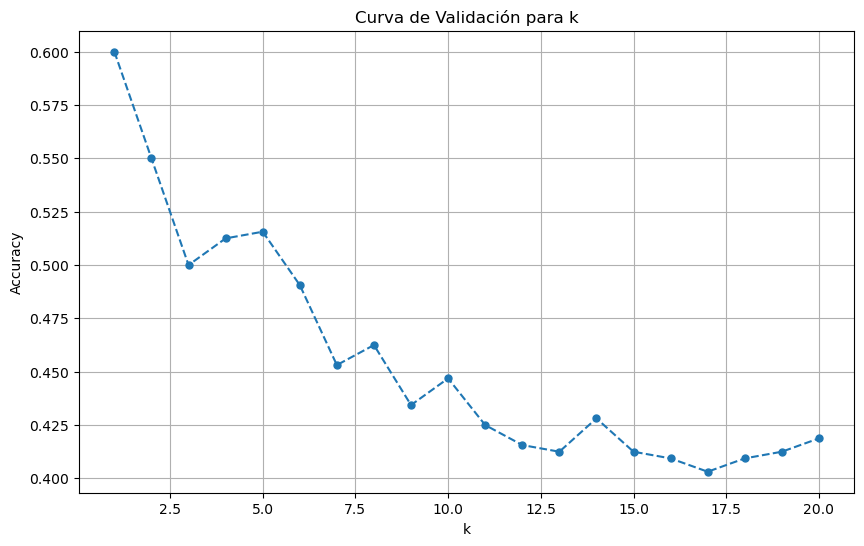

In [20]:
k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_smote, y_train_smote)
    y_pred = knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='dashed', markersize=5)
plt.title('Curva de Validación para k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

La curva de validación para los valores de k mostró que la precisión varía significativamente con diferentes valores de k, alcanzando su punto más alto cuando k es 1. Esto sugiere que valores más bajos de k son mejores para este conjunto de datos específico después de aplicar SMOTE, lo cual es consistente con los resultados de GridSearchCV que también seleccionó k=1 como óptimo.

##### Fase4: Ensemble de Modelos
A continuación, se aplicará PCA y se hará uso de un ensemble (Voting Classifier) para combinar K-NN con otros clasificadores.

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


# Dividir los datos
X = df.drop('quality', axis=1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalización
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Balanceo de clases con SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=0.95)  # Conservar el 95% de la varianza
X_train_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test)

# Ensemble de Modelos
knn = KNeighborsClassifier(n_neighbors=3)
rf = RandomForestClassifier(random_state=42)
lr = LogisticRegression(random_state=42)

voting_clf = VotingClassifier(estimators=[('knn', knn), ('rf', rf), ('lr', lr)], voting='soft')
voting_clf.fit(X_train_pca, y_train_smote)

# Predicciones y evaluación
y_pred = voting_clf.predict(X_test_pca)
print("\nMatriz de Confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))



Matriz de Confusión:
 [[ 0  1  0  0  0  0]
 [ 2  3  1  4  0  0]
 [ 3 14 79 31  3  0]
 [ 2 11 27 60 27  5]
 [ 0  0  0  7 29  6]
 [ 0  0  0  0  4  1]]

Reporte de Clasificación:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.10      0.30      0.15        10
           5       0.74      0.61      0.67       130
           6       0.59      0.45      0.51       132
           7       0.46      0.69      0.55        42
           8       0.08      0.20      0.12         5

    accuracy                           0.54       320
   macro avg       0.33      0.38      0.33       320
weighted avg       0.61      0.54      0.56       320



Finalmente, se introdujo un enfoque de ensemble utilizando el método de votación con K-NN, un Random Forest y una Regresión Logística.

A pesar de que el modelo de ensemble generalmente es una buena estrategia para mejorar la precisión al combinar las fortalezas de modelos individuales, la precisión general cayó al 
54%.

Sin embargo, esto podría estar reflejando una mejoría en la capacidad del modelo de generalizar, en lugar de ajustarse excesivamente a las clases mayoritarias. Es notable el incremento en la sensibilidad (recall) de las clases minoritarias, lo cual puede indicar que el modelo de ensemble es más equilibrado en su capacidad de reconocer diferentes clases, incluso si eso no se traduce en una mejor precisión general.

#### 4.5. Neural Network

Las Neural Networks son modelos de machine learning que se basan en la creación de una red de neuronas artificiales. Estas neuronas artificiales se basan en el funcionamiento de las neuronas biológicas, que se comunican entre sí mediante impulsos eléctricos. En el caso de las neuronas artificiales, estas se comunican entre sí mediante la propagación de los datos de entrada a través de una red de neuronas, donde cada una de estas neuronas posee una función de activación que determina si la neurona se activa o no.

In [3]:
!pip install tensorflow
!pip install keras
from tensorflow import keras

from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/80/6f/57d36f6507e432d7fc1956b2e9e8530c5c2d2bfcd8821bcbfae271cd6688/tensorflow-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.14.0 from https://files.pythonhosted.org/packages/ad/6e/1bfe367855dd87467564f7bf9fa14f3b17889988e79598bc37bf18f5ffb6/tensorflow_intel-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     ---------------------------------------- 57.5

El proceso comienza organizando los datos para que el modelo pueda entenderlos fácilmente. Se separa la información que queremos predecir y se ajustan los valores para que todos tengan la misma escala, lo cual es esencial para un análisis efectivo.

El corazón del código es la creación de un modelo de red neuronal. Piensa en ello como una estructura que aprende de los datos, compuesta por capas que toman decisiones y mecanismos diseñados para evitar que el modelo se 'aprenda de memoria' los datos, y en su lugar pueda generalizar bien.

Para asegurarnos de que nuestro modelo es robusto y funciona con diferentes datos, lo ponemos a prueba con distintas muestras del conjunto total. Esto lo hacemos dividiéndolos en cinco grupos y entrenando y validando el modelo con cada grupo.

Si el modelo no mejora con el tiempo, haremos ajustes para ayudarlo a mejorar. Y al final, después de entrenarlo con muchos ejemplos, veremos qué tan preciso es con datos nuevos y proporcionaremos esa precisión en forma de porcentaje.

In [ ]:
# Preprocesamiento
X = df.drop("quality", axis=1)
y = to_categorical(df["quality"])

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Definir la arquitectura mejorada del modelo
def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_scaled.shape[1], activation='relu'))
    model.add(Dropout(0.3))  # Capa de Dropout para reducir el sobreajuste
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(y.shape[1], activation='softmax'))
    
    optimizer = Adam(learning_rate=0.001)  # Puedes ajustar la tasa de aprendizaje
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Validación cruzada estratificada
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in kfold.split(X_scaled, np.argmax(y, axis=1)):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    model = create_model()

    # Reducir la tasa de aprendizaje cuando la métrica deja de mejorar
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[reduce_lr])

# Evaluar el modelo
loss, accuracy = model.evaluate(X_val, y_val)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Epoch 1/100
40/40 [==============================] - 1s 5ms/step - loss: 1.7001 - accuracy: 0.4300 - val_loss: 1.2459 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 0s 9ms/step - loss: 1.2140 - accuracy: 0.5231 - val_loss: 1.0652 - val_accuracy: 0.5688 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 0s 2ms/step - loss: 1.0991 - accuracy: 0.5637 - val_loss: 1.0303 - val_accuracy: 0.5844 - lr: 0.0010
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 1.0460 - accuracy: 0.5794 - val_loss: 1.0099 - val_accuracy: 0.5875 - lr: 0.0010
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 1.0366 - accuracy: 0.5942 - val_loss: 0.9998 - val_accuracy: 0.5969 - lr: 0.0010
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 1.0155 - accuracy: 0.5809 - val_loss: 0.9934 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 1.0

El modelo muestra un rendimiento modesto con una precisión de aproximadamente 59.56%. Esto indica que mientras el modelo puede aprender del conjunto de datos para predecir la calidad, hay margen de mejora. Algunas estrategias para aumentar la precisión podrían incluir:

- Experimentar con la arquitectura del modelo (número de capas, unidades por capa, etc.).
- Utilizar técnicas más avanzadas de regularización.
- Explorar más en el ajuste de hiperparámetros (tasa de aprendizaje, tamaño de lote, etc.).
- Incrementar la cantidad de datos o realizar técnicas de aumento de datos si es posible.
- Examinar las características para entender si todas son útiles o si algunas pueden estar introduciendo ruido en el modelo.

Además, es importante considerar la métrica de precisión en el contexto del problema. Si algunas clases son más importantes que otras (por ejemplo, es más crítico identificar correctamente los vinos de alta calidad), podrían ser necesarias métricas adicionales como la precisión y recuperación por clase, o incluso una matriz de confusión para entender mejor el rendimiento del modelo en diferentes categorías de calidad.

In [ ]:
# Preprocesamiento
X = df.drop("quality", axis=1)
y = df["quality"] - min(df["quality"])  # Asegurar que las etiquetas comiencen desde 0
y_categorical = to_categorical(y)

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balanceo de clases usando SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

# Convertir y_balanced a one-hot encoding
y_balanced_categorical = to_categorical(y_balanced)

# Definir la arquitectura mejorada del modelo
def create_model():
    model = Sequential()
    model.add(Dense(256, input_dim=X_balanced.shape[1], activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(y_balanced_categorical.shape[1], activation='softmax'))
    
    optimizer = Adam(learning_rate=0.0005)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Validación cruzada estratificada
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in kfold.split(X_balanced, y_balanced):
    X_train, X_val = X_balanced[train_idx], X_balanced[val_idx]
    y_train, y_val = y_balanced_categorical[train_idx], y_balanced_categorical[val_idx]
    
    model = create_model()

    # Reducir la tasa de aprendizaje cuando la métrica deja de mejorar
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

    # Calcular pesos de las clases
    weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_balanced), y=y_balanced)
    class_weights = {i: w for i, w in enumerate(weights)}

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[reduce_lr], class_weight=class_weights)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_val, y_val)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Epoch 1/100
103/103 [==============================] - 1s 4ms/step - loss: 1.4536 - accuracy: 0.4030 - val_loss: 1.1757 - val_accuracy: 0.5183 - lr: 5.0000e-04
Epoch 2/100
103/103 [==============================] - 0s 2ms/step - loss: 1.1751 - accuracy: 0.5138 - val_loss: 1.0346 - val_accuracy: 0.5746 - lr: 5.0000e-04
Epoch 3/100
103/103 [==============================] - 0s 3ms/step - loss: 1.0673 - accuracy: 0.5551 - val_loss: 0.9655 - val_accuracy: 0.6271 - lr: 5.0000e-04
Epoch 4/100
103/103 [==============================] - 0s 3ms/step - loss: 1.0167 - accuracy: 0.5909 - val_loss: 0.9110 - val_accuracy: 0.6406 - lr: 5.0000e-04
Epoch 5/100
103/103 [==============================] - 0s 3ms/step - loss: 0.9613 - accuracy: 0.6169 - val_loss: 0.8806 - val_accuracy: 0.6699 - lr: 5.0000e-04
Epoch 6/100
103/103 [==============================] - 0s 2ms/step - loss: 0.9381 - accuracy: 0.6230 - val_loss: 0.8497 - val_accuracy: 0.6785 - lr: 5.0000e-04
Epoch 7/100
103/103 [===================

La inclusión de SMOTE para el balanceo de clases y los ajustes en la arquitectura del modelo y en el proceso de entrenamiento han llevado a una mejora considerable en la precisión del modelo, pasando de una precisión de 59.56% a 83.48%. 

Esto sugiere que los pasos adicionales de preprocesamiento y la capacidad incrementada del modelo han tenido un impacto positivo en su habilidad para clasificar correctamente la calidad.

Sin embargo, aunque una precisión de 83.48% es prometedora, sería importante examinar otras métricas de rendimiento, como la precisión y la sensibilidad por clase, especialmente en un conjunto de datos balanceado sintéticamente. Esto es porque la precisión global puede no reflejar completamente cómo el modelo actúa en cada clase individual, especialmente en casos de clasificación multiclase con clases desbalanceadas.

26/26 [==============================] - 0s 2ms/step - loss: 0.4328 - accuracy: 0.8311
Accuracy: 83.11%


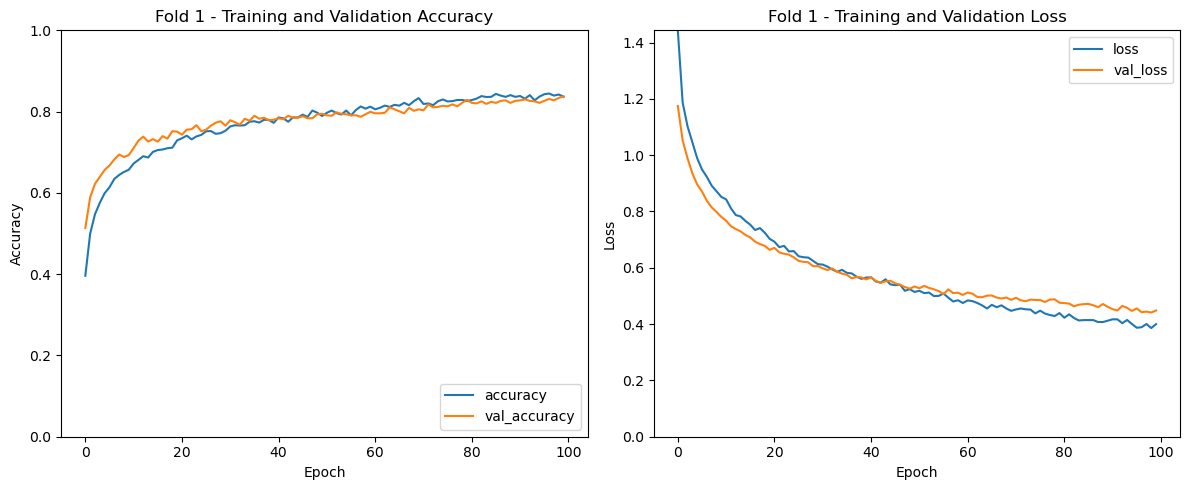

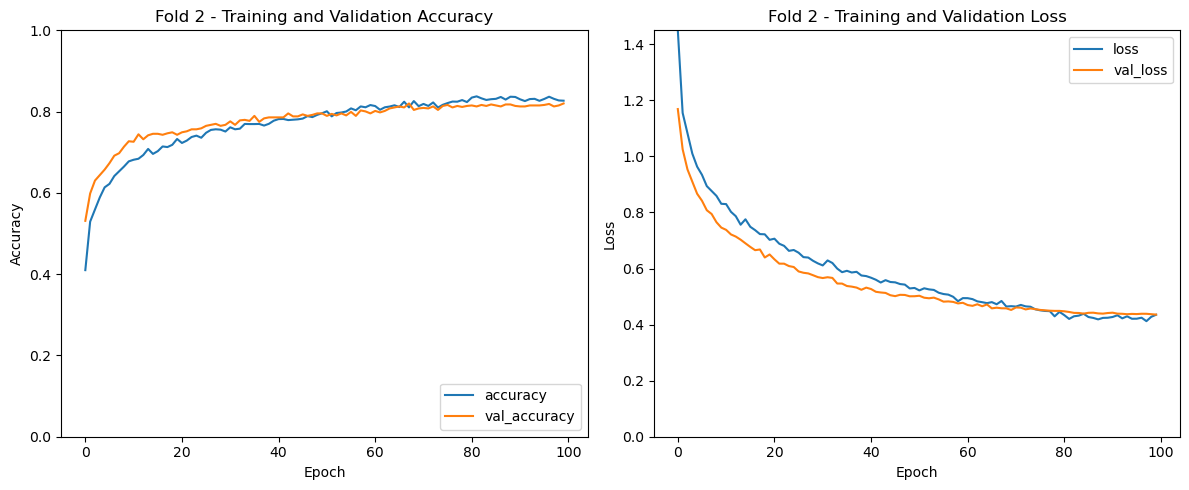

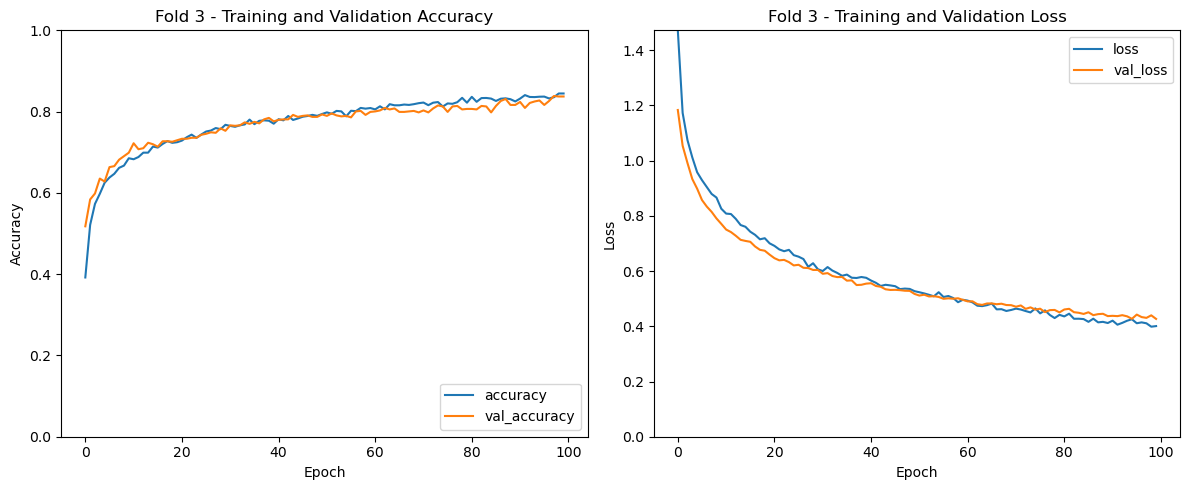

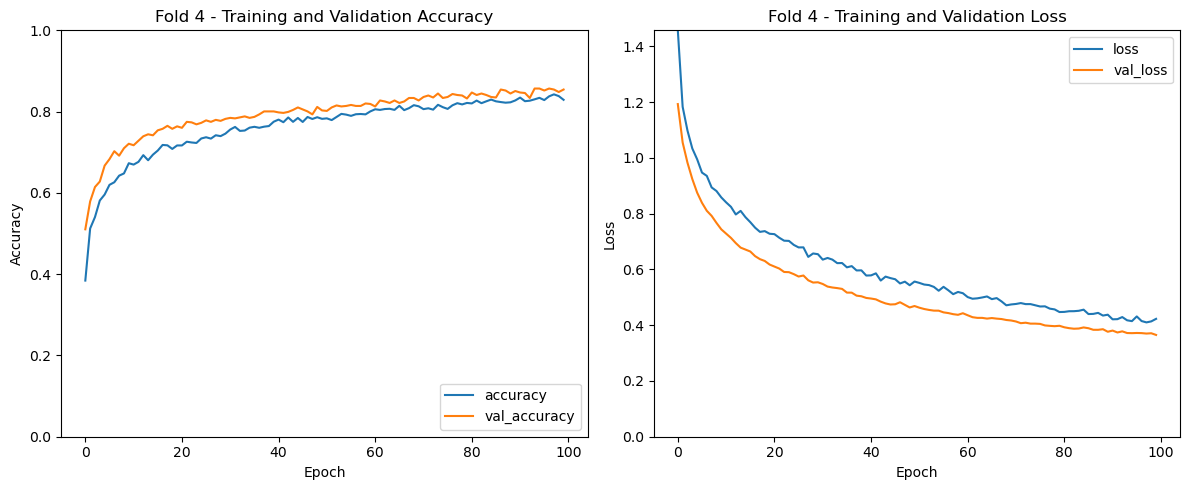

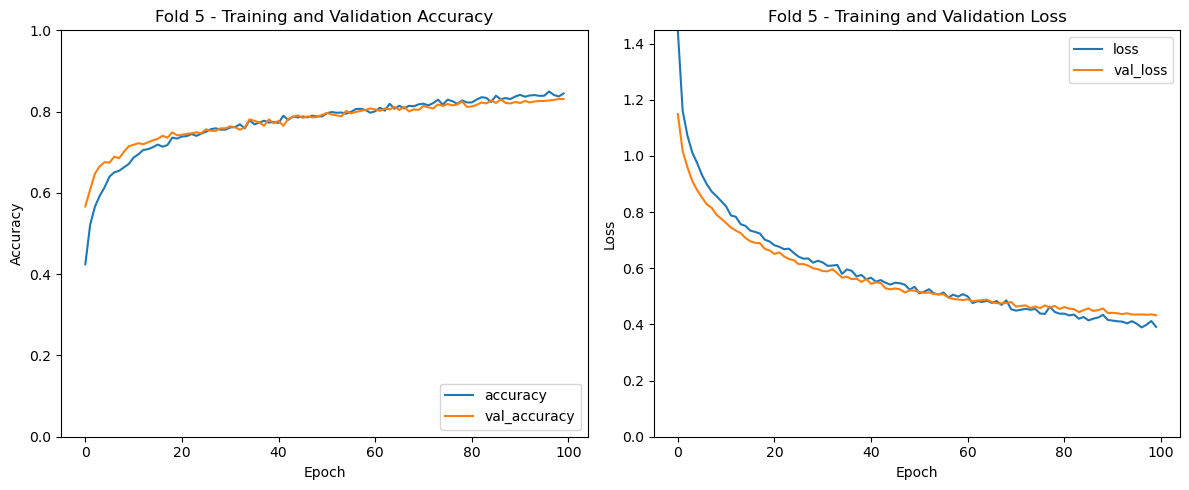

In [ ]:
# Validación cruzada estratificada
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
history_list = []

for train_idx, val_idx in kfold.split(X_balanced, y_balanced):
    X_train, X_val = X_balanced[train_idx], X_balanced[val_idx]
    y_train, y_val = y_balanced_categorical[train_idx], y_balanced_categorical[val_idx]
    
    model = create_model()

    # Reducir la tasa de aprendizaje cuando la métrica deja de mejorar
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

    # Calcular pesos de las clases
    weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_balanced), y=y_balanced)
    class_weights = {i: w for i, w in enumerate(weights)}

    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[reduce_lr], class_weight=class_weights, verbose=0)
    history_list.append(history)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_val, y_val)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Visualización de la evolución de la precisión y la pérdida a lo largo de las épocas
for i, history in enumerate(history_list):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'Fold {i+1} - Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, max(history.history['loss'] + history.history['val_loss'])])
    plt.legend(loc='upper right')
    plt.title(f'Fold {i+1} - Training and Validation Loss')
    
    plt.tight_layout()
    plt.show()


Las imágenes proporcionadas muestran las gráficas de precisión y pérdida de la validación y entrenamiento a lo largo de las épocas para un proceso de validación cruzada estratificada con 5 pliegues (folds).

En cada gráfica de precisión (izquierda), la línea azul representa la precisión del conjunto de entrenamiento (accuracy), y la línea naranja representa la precisión del conjunto de validación (val_accuracy). En las gráficas de pérdida (derecha), la línea azul muestra la pérdida en el conjunto de entrenamiento (loss), mientras que la línea naranja muestra la pérdida en el conjunto de validación (val_loss).

las gráficas indican un buen comportamiento del modelo con un aprendizaje estable y sin señales claras de sobreajuste o subajuste. El uso de la validación cruzada estratificada garantiza que el modelo se generaliza bien a diferentes subdivisiones del conjunto de datos.